In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt
from pathlib import Path

from swarmpal.io import PalDataItem, create_paldata
from swarmpal.experimental import LocalForwardMagneticModel

from swarmpal_mma.pal_processes import MMA_SHA_2E
from swarmpal_mma.Plotting.map_plot import map_surface_rtp


## Set configurations

In [3]:
# Global parameters (should always remain the same)
MODEL = "'Model' = 'CHAOS-Core' + 'CHAOS-Static'"
MODEL_WITH_IONO = "'Model' = 'CHAOS-Core' + 'CHAOS-Static' + 'MIO_SHA_2C'"
VIRES_AUXILIARIES = ["MLT", "QDLat", "Dst", "QDBasis", "DipoleAxisVector"]
AVAILABLE_DATASETS = {"Swarm-A": "SW_OPER_MAGA_LR_1B", "Swarm-B": "SW_OPER_MAGB_LR_1B"}
SAMPLING_STEP = "PT25S"

# Tunable parameters
PARAMS = {"LT_limit": 6, "min_gm_lat": 0, "max_gm_lat": 65}
# TODO: See what should be included here from MMA_2E/utils/Config.py

# Local settings (changes with each run) - these determine what external data is used
START_TIME = dt.datetime(2024, 1, 1)
END_TIME = dt.datetime(2024, 1, 7)
# START_TIME = dt.datetime(2024, 10, 1)
# END_TIME = dt.datetime(2024, 10, 2)
SPACECRAFTS_TO_USE = ["Swarm-A", "Swarm-B"]  # corresponds to AVAILABLE_DATASETS

## Fetch data using SwarmPAL

In [4]:
def get_paldatatime_vires_config(
    collection=None, start_time=None, end_time=None, model=None
):
    """Set of options which are passed through to viresclient
    For options, see https://swarmpal.readthedocs.io/en/latest/api/io.html#swarmpal.io.PalDataItem.from_vires
    """
    return dict(
        collection=collection,
        measurements=["B_NEC"],
        models=[model],
        auxiliaries=VIRES_AUXILIARIES,
        sampling_step=SAMPLING_STEP,
        start_time=start_time,
        end_time=end_time,
        server_url="https://vires.services/ows",
        options=dict(asynchronous=True, show_progress=True),
    )


start_time = START_TIME
end_time = END_TIME
model = MODEL
data_config = {
    spacecraft: get_paldatatime_vires_config(
        collection=AVAILABLE_DATASETS.get(spacecraft),
        start_time=start_time,
        end_time=end_time,
        model=model,
    )
    for spacecraft in SPACECRAFTS_TO_USE
}
data_config

{'Swarm-A': {'collection': 'SW_OPER_MAGA_LR_1B',
  'measurements': ['B_NEC'],
  'models': ["'Model' = 'CHAOS-Core' + 'CHAOS-Static'"],
  'auxiliaries': ['MLT', 'QDLat', 'Dst', 'QDBasis', 'DipoleAxisVector'],
  'sampling_step': 'PT25S',
  'start_time': datetime.datetime(2024, 1, 1, 0, 0),
  'end_time': datetime.datetime(2024, 1, 7, 0, 0),
  'server_url': 'https://vires.services/ows',
  'options': {'asynchronous': True, 'show_progress': True}},
 'Swarm-B': {'collection': 'SW_OPER_MAGB_LR_1B',
  'measurements': ['B_NEC'],
  'models': ["'Model' = 'CHAOS-Core' + 'CHAOS-Static'"],
  'auxiliaries': ['MLT', 'QDLat', 'Dst', 'QDBasis', 'DipoleAxisVector'],
  'sampling_step': 'PT25S',
  'start_time': datetime.datetime(2024, 1, 1, 0, 0),
  'end_time': datetime.datetime(2024, 1, 7, 0, 0),
  'server_url': 'https://vires.services/ows',
  'options': {'asynchronous': True, 'show_progress': True}}}

In [5]:
data_in = create_paldata(
    **{
        label: PalDataItem.from_vires(**data_params)
        for label, data_params in data_config.items()
    }
)
print(data_in)

Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ] [1/1] 
Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (3.351MB)
Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ] [1/1] 
Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (3.351MB)


<xarray.DataTree 'paldata'>
Group: /
├── Group: /Swarm-A
│       Dimensions:           (Timestamp: 20736, DipoleAxisVector_dim1: 3, NEC: 3,
│                              QDBasis_dim1: 2, QDBasis_dim2: 2)
│       Coordinates:
│         * Timestamp         (Timestamp) datetime64[ns] 166kB 2024-01-01 ... 2024-01...
│         * NEC               (NEC) <U1 12B 'N' 'E' 'C'
│       Dimensions without coordinates: DipoleAxisVector_dim1, QDBasis_dim1,
│                                       QDBasis_dim2
│       Data variables:
│           Spacecraft        (Timestamp) object 166kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
│           Longitude         (Timestamp) float64 166kB 103.7 103.6 ... -65.79 -61.45
│           MLT               (Timestamp) float64 166kB 6.575 6.576 ... 22.21 0.07686
│           Radius            (Timestamp) float64 166kB 6.86e+06 6.86e+06 ... 6.845e+06
│           QDLat             (Timestamp) float64 166kB -16.27 -18.05 ... 86.95 87.31
│           DipoleAxisVector  (Timestamp, 

## Apply the MMA_SHA_2E process

In [6]:
mma_process = MMA_SHA_2E()
mma_process.set_config()

In [7]:
data_out = mma_process(data_in)

Data range and integration time 8771.999710648148 8766.0 0.3333333333333333
Done 0 out of 18



In [8]:
print(data_out)

<xarray.DataTree 'paldata'>
Group: /
│   Attributes:
│       PAL_meta:  {"MMA_SHA_2E": {"datasets": null, "local_time_limit": 6.0, "ma...
├── Group: /Swarm-A
│       Dimensions:           (Timestamp: 20736, DipoleAxisVector_dim1: 3, NEC: 3,
│                              QDBasis_dim1: 2, QDBasis_dim2: 2)
│       Coordinates:
│         * Timestamp         (Timestamp) datetime64[ns] 166kB 2024-01-01 ... 2024-01...
│         * NEC               (NEC) <U1 12B 'N' 'E' 'C'
│       Dimensions without coordinates: DipoleAxisVector_dim1, QDBasis_dim1,
│                                       QDBasis_dim2
│       Data variables:
│           Spacecraft        (Timestamp) object 166kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
│           Longitude         (Timestamp) float64 166kB 103.7 103.6 ... -65.79 -61.45
│           MLT               (Timestamp) float64 166kB 6.575 6.576 ... 22.21 0.07686
│           Radius            (Timestamp) float64 166kB 6.86e+06 6.86e+06 ... 6.845e+06
│           QDLat          

## Plotting

In [9]:
from swarmpal_mma.Plotting.map_plot import map_surface_rtp

In [10]:
data_out["MMA_SHA_2E"]["qs"][0, :]

<xarray.DataArray 'qs' (15: 15)> Size: 120B
array([10.16706219, -9.96113093, -4.01524762,  2.77991824, -0.4718442 ,
       -0.70954416,  1.39123177, -5.65849696, -0.8547018 ,  0.14157149,
        1.36632746,  0.39789554, -0.17209657,  2.39512448,  0.22605438])
Dimensions without coordinates: 15

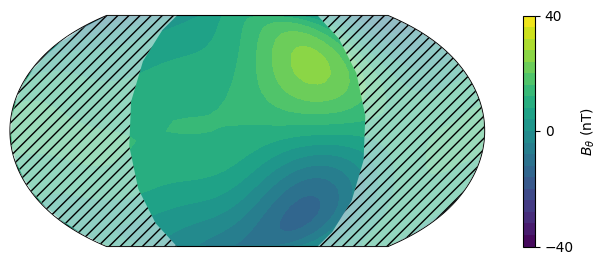

In [11]:
map_surface_rtp(data_out["MMA_SHA_2E"]["qs"][0, :])

## Using MSS

Download a file from `MSS-1-A/VFM/SCI-LR` at <https://mss.must.edu.mo/data.html>. Here we will demonstrate with a merged 7-day file. We can load it using swarmpal...

In [12]:
file = Path("MSS1A_TEST_VFM_L2_MAG_SCI-LR_20240101T000000_20240106T235959.cdf")
assert file.exists()
data_mss_in = create_paldata(
    **{"MSS1A_TEST_VFM_L2_MAG_SCI-LR": PalDataItem.from_file(file)}
)
print(data_mss_in)

<xarray.DataTree 'paldata'>
Group: /
└── Group: /MSS1A_TEST_VFM_L2_MAG_SCI-LR
        Dimensions:    (Timestamp: 604800, B_VFM_dim_1: 3, B_NEC_dim_1: 3,
                        q_NEC_CRF_dim_1: 4)
        Coordinates:
          * Timestamp  (Timestamp) datetime64[ns] 5MB 2024-01-01 ... 2024-01-06T23:59:59
        Dimensions without coordinates: B_VFM_dim_1, B_NEC_dim_1, q_NEC_CRF_dim_1
        Data variables:
            Radius     (Timestamp) float64 5MB 6.837e+06 6.837e+06 ... 6.848e+06
            Latitude   (Timestamp) float64 5MB 30.78 30.81 30.84 ... 29.81 29.78 29.75
            Longitude  (Timestamp) float64 5MB 64.72 64.78 64.84 ... 118.9 119.0 119.0
            B_VFM      (Timestamp, B_VFM_dim_1) float64 15MB 3.561e+04 ... 2.385e+04
            B_NEC      (Timestamp, B_NEC_dim_1) float64 15MB 2.539e+04 ... 2.714e+04
            F          (Timestamp) float64 5MB 3.823e+04 3.825e+04 ... 3.825e+04
            q_NEC_CRF  (Timestamp, q_NEC_CRF_dim_1) float64 19MB 0.8789 ... -0.44

Note that since we didn't fetch the data from VirES, there are no geomagnetic field model predictions, which are required to use the MMA toolbox.

As an experimental SwarmPAL feature, we can evaluate the CHAOS field locally (rather than using the VirES API):

(NB we will just use the CHAOS-Core field in this case)

In [13]:
from swarmpal.experimental import LocalForwardMagneticModel


process_local_model = LocalForwardMagneticModel()
process_local_model.set_config(
    dataset="MSS1A_TEST_VFM_L2_MAG_SCI-LR",
    model_descriptor="CHAOS-Core",
)
data_mss_in = process_local_model(data_mss_in)
print(data_mss_in)

<xarray.DataTree 'paldata'>
Group: /
│   Attributes:
│       PAL_meta:  {"LocalForwardMagneticModel": {"dataset": "MSS1A_TEST_VFM_L2_M...
└── Group: /MSS1A_TEST_VFM_L2_MAG_SCI-LR
        Dimensions:           (Timestamp: 604800, B_VFM_dim_1: 3, B_NEC_dim_1: 3,
                               q_NEC_CRF_dim_1: 4)
        Coordinates:
          * Timestamp         (Timestamp) datetime64[ns] 5MB 2024-01-01 ... 2024-01-0...
        Dimensions without coordinates: B_VFM_dim_1, B_NEC_dim_1, q_NEC_CRF_dim_1
        Data variables:
            Radius            (Timestamp) float64 5MB 6.837e+06 6.837e+06 ... 6.848e+06
            Latitude          (Timestamp) float64 5MB 30.78 30.81 30.84 ... 29.78 29.75
            Longitude         (Timestamp) float64 5MB 64.72 64.78 64.84 ... 119.0 119.0
            B_VFM             (Timestamp, B_VFM_dim_1) float64 15MB 3.561e+04 ... 2.3...
            B_NEC             (Timestamp, B_NEC_dim_1) float64 15MB 2.539e+04 ... 2.7...
            F                 

In [14]:
# NB for now we must instruct the MMA process to use the specific variable names
mma_process = MMA_SHA_2E()
mma_process.set_config(
    measurement_varname="B_NEC",
    model_varname="B_NEC_CHAOS-Core",
)
data_mss_out = mma_process(data_mss_in)

Data range and integration time 8772.972199074075 8766.0 0.3333333333333333
Done 0 out of 21



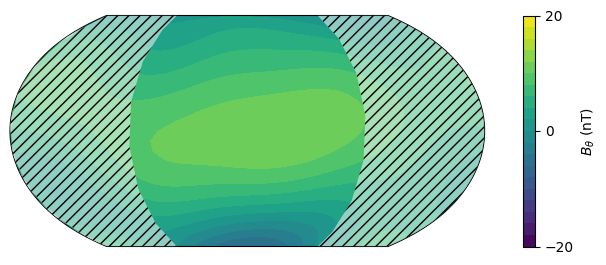

In [15]:
map_surface_rtp(data_mss_out["MMA_SHA_2E"]["qs"][0, :])

## Using a combination of data sources

In [17]:
# Fetch remote data, and load local data
data = create_paldata(
    **{
        "Swarm-A": PalDataItem.from_vires(
            collection="SW_OPER_MAGA_LR_1B",
            measurements=["B_NEC"],
            models=["CHAOS-Core"],
            sampling_step="PT25S",
            start_time="2024-01-01",
            end_time="2024-01-07",
            server_url="https://vires.services/ows",
            options=dict(asynchronous=False, show_progress=True),
        ),
        "Swarm-B": PalDataItem.from_vires(
            collection="SW_OPER_MAGB_LR_1B",
            measurements=["B_NEC"],
            models=["CHAOS-Core"],
            sampling_step="PT25S",
            start_time="2024-01-01",
            end_time="2024-01-07",
            server_url="https://vires.services/ows",
            options=dict(asynchronous=False, show_progress=True),
        ),
        "MSS-1-A": PalDataItem.from_file(
            Path("MSS1A_TEST_VFM_L2_MAG_SCI-LR_20240101T000000_20240106T235959.cdf")
        )
    }
)
# Downsample the MSS-1-A data to match the Swarm data
data["MSS-1-A"] = data["MSS-1-A"].sel(Timestamp=data["MSS-1-A"].ds["Timestamp"][::25])
# Apply the local forward model to the MSS-1-A data
print("Computing local forward model...")
process_local_model = LocalForwardMagneticModel()
process_local_model.set_config(
    dataset="MSS-1-A",
    model_descriptor="CHAOS-Core",
)
process_local_model(data)
print(data)

Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (1.689MB)
Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (1.689MB)


Computing local forward model...
<xarray.DataTree 'paldata'>
Group: /
│   Attributes:
│       PAL_meta:  {"LocalForwardMagneticModel": {"dataset": "MSS-1-A", "model_de...
├── Group: /Swarm-A
│       Dimensions:           (Timestamp: 20736, NEC: 3)
│       Coordinates:
│         * Timestamp         (Timestamp) datetime64[ns] 166kB 2024-01-01 ... 2024-01...
│         * NEC               (NEC) <U1 12B 'N' 'E' 'C'
│       Data variables:
│           Spacecraft        (Timestamp) object 166kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
│           Longitude         (Timestamp) float64 166kB 103.7 103.6 ... -65.79 -61.45
│           Radius            (Timestamp) float64 166kB 6.86e+06 6.86e+06 ... 6.845e+06
│           B_NEC             (Timestamp, NEC) float64 498kB 2.978e+04 ... 4.593e+04
│           Latitude          (Timestamp) float64 166kB -7.888 -9.478 ... 81.79 83.28
│           B_NEC_CHAOS-Core  (Timestamp, NEC) float64 498kB 2.979e+04 ... 4.592e+04
│       Attributes:
│           Sources:     

In [18]:
mma_process = MMA_SHA_2E()
mma_process.set_config(
    measurement_varname="B_NEC",
    model_varname="B_NEC_CHAOS-Core",
)
mma_process(data);
print(data)

Data range and integration time 8772.97193287037 8766.0 0.3333333333333333
Done 0 out of 21

<xarray.DataTree 'paldata'>
Group: /
│   Attributes:
│       PAL_meta:  {"LocalForwardMagneticModel": {"dataset": "MSS-1-A", "model_de...
├── Group: /Swarm-A
│       Dimensions:           (Timestamp: 20736, NEC: 3)
│       Coordinates:
│         * Timestamp         (Timestamp) datetime64[ns] 166kB 2024-01-01 ... 2024-01...
│         * NEC               (NEC) <U1 12B 'N' 'E' 'C'
│       Data variables:
│           Spacecraft        (Timestamp) object 166kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
│           Longitude         (Timestamp) float64 166kB 103.7 103.6 ... -65.79 -61.45
│           Radius            (Timestamp) float64 166kB 6.86e+06 6.86e+06 ... 6.845e+06
│           B_NEC             (Timestamp, NEC) float64 498kB 2.978e+04 ... 4.593e+04
│           Latitude          (Timestamp) float64 166kB -7.888 -9.478 ... 81.79 83.28
│           B_NEC_CHAOS-Core  (Timestamp, NEC) float64 498kB 2.979e+04

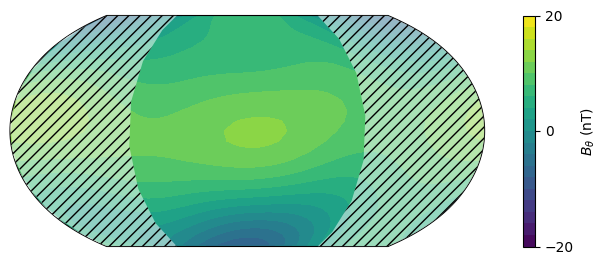

In [19]:
map_surface_rtp(data["MMA_SHA_2E"]["qs"][0, :])